In [1]:
import numpy
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.colors import LinearSegmentedColormap
import xarray
import cmocean
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature
import statsmodels.stats.multitest
import pyresample

/homes/ebach/miniconda3/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
data1 = xarray.open_dataset('data/data01.nc')
data5 = xarray.open_dataset('data/data05.nc')
data15 = xarray.open_dataset('data/data15.nc')

lon = numpy.load('data/lon.npy')
lat = numpy.load('data/lat.npy')

lat2 = numpy.arange(-90, -90 + 241*0.75, 0.75)
lon2 = numpy.arange(0, 360, 0.75)

# Resample from reduced Gaussian grid to regular grid for plotting
orig_def = pyresample.geometry.SwathDefinition(lons=lon - 180, lats=lat)
targ_def = pyresample.geometry.SwathDefinition(lons=numpy.meshgrid(lon2, lat2)[0].flatten() - 180,
                                               lats=numpy.meshgrid(lon2, lat2)[1].flatten())

In [34]:
all_dat2 = numpy.fromfile('vortah850_daily365_1979-2017.dat', dtype='f8').reshape([14235, 88838])

In [35]:
a = numpy.var(all_dat2, axis=0)

In [36]:
numpy.sqrt(a)

array([  2.78281998e-05,   2.78035527e-05,   2.78549083e-05, ...,
         1.25184707e-05,   1.12024956e-05,   1.07186622e-05])

In [ ]:
data1['fdr_vort_to_sst'] = (('cell', 'delay_sig'), numpy.full([88838, 7], numpy.NaN))
data1['fdr_sst_to_vort'] = (('cell', 'delay_sig'), numpy.full([88838, 7], numpy.NaN))

for cell in range(1, 88839):
    data1['fdr_vort_to_sst'][cell - 1, :] = statsmodels.stats.multitest.multipletests(data1['sig_vort_to_sst'][cell - 1, numpy.arange(0, 35, 5)],
                                                                                      alpha=0.1, method='fdr_bh')[0]
    data1['fdr_sst_to_vort'][cell - 1, :] = statsmodels.stats.multitest.multipletests(data1['sig_sst_to_vort'][cell - 1, numpy.arange(0, 35, 5)],
                                                                                      alpha=0.1, method='fdr_bh')[0]

/homes/ebach/miniconda3/lib/python3.6/site-packages/statsmodels/stats/multitest.py:320: RuntimeWarning: invalid value encountered in less_equal
  reject = pvals_sorted <= ecdffactor*alpha


In [ ]:
data5['fdr_vort_to_sst'] = (('cell', 'delay_sig'), numpy.full([88838, 8], numpy.NaN))
data5['fdr_sst_to_vort'] = (('cell', 'delay_sig'), numpy.full([88838, 8], numpy.NaN))

for cell in range(1, 88839):
    data5['fdr_vort_to_sst'][cell - 1, :] = statsmodels.stats.multitest.multipletests(data5['sig_vort_to_sst'][cell - 1, numpy.arange(0, 16, 2)],
                                                                                      alpha=0.1, method='fdr_bh')[0]
    data5['fdr_sst_to_vort'][cell - 1, :] = statsmodels.stats.multitest.multipletests(data5['sig_sst_to_vort'][cell - 1, numpy.arange(0, 16, 2)],
                                                                                      alpha=0.1, method='fdr_bh')[0]

In [10]:
data15['fdr_vort_to_sst'] = (('cell', 'delay_sig'), numpy.full([88838, 10], numpy.NaN))
data15['fdr_sst_to_vort'] = (('cell', 'delay_sig'), numpy.full([88838, 10], numpy.NaN))

for cell in range(1, 88839):
    data15['fdr_vort_to_sst'][cell - 1, :] = statsmodels.stats.multitest.multipletests(data15['sig_vort_to_sst'][cell - 1, numpy.arange(0, 10)],
                                                                                       alpha=0.1, method='fdr_bh')[0]
    data15['fdr_sst_to_vort'][cell - 1, :] = statsmodels.stats.multitest.multipletests(data15['sig_sst_to_vort'][cell - 1, numpy.arange(0, 10)],
                                                                                       alpha=0.1, method='fdr_bh')[0]

/homes/ebach/miniconda3/lib/python3.6/site-packages/statsmodels/stats/multitest.py:320: RuntimeWarning: invalid value encountered in less_equal
  reject = pvals_sorted <= ecdffactor*alpha


In [5]:
data1 = xarray.open_dataset('data1p.nc')
data5 = xarray.open_dataset('data5p.nc')
data15 = xarray.open_dataset('data15p.nc')

In [55]:
data1.to_netcdf('data1p.nc')
data5.to_netcdf('data5p.nc')
data15.to_netcdf('data15p.nc')

In [4]:
persist_vort_to_sst = numpy.full([88838], 0.0)
persist_sst_to_vort = numpy.full([88838], 0.0)
for a in range(7):
    mask = (persist_vort_to_sst >= 5*(a - 1)).astype(bool) & (data1['fdr_vort_to_sst'][:, a].values != 0)
    persist_vort_to_sst[mask] = (data1['fdr_vort_to_sst'][:, a].values*5*a)[mask]
    
    mask = (persist_sst_to_vort >= 5*(a - 1)).astype(bool) & (data1['fdr_sst_to_vort'][:, a].values != 0)
    persist_sst_to_vort[mask] = (data1['fdr_sst_to_vort'][:, a].values*5*a)[mask]

persist_vort_to_sst[(data1['fdr_vort_to_sst'][:, 0] == 0) & (persist_vort_to_sst == 0)] = numpy.NaN
persist_sst_to_vort[(data1['fdr_sst_to_vort'][:, 0] == 0) & (persist_sst_to_vort == 0)] = numpy.NaN

In [5]:
persist5_vort_to_sst = numpy.full([88838], 0.0)
persist5_sst_to_vort = numpy.full([88838], 0.0)
for a in range(8):
    mask = (persist5_vort_to_sst >= 10*(a - 1)).astype(bool) & (data5['fdr_vort_to_sst'][:, a].values != 0)
    persist5_vort_to_sst[mask] = (data5['fdr_vort_to_sst'][:, a].values*10*a)[mask]
    
    mask = (persist5_sst_to_vort >= 10*(a - 1)).astype(bool) & (data5['fdr_sst_to_vort'][:, a].values != 0)
    persist5_sst_to_vort[mask] = (data5['fdr_sst_to_vort'][:, a].values*10*a)[mask]

persist5_vort_to_sst[(data5['fdr_vort_to_sst'][:, 0] == 0) & (persist5_vort_to_sst == 0)] = numpy.NaN
persist5_sst_to_vort[(data5['fdr_sst_to_vort'][:, 0] == 0) & (persist5_sst_to_vort == 0)] = numpy.NaN

In [6]:
persist15_vort_to_sst = numpy.full([88838], 0.0)
persist15_sst_to_vort = numpy.full([88838], 0.0)
for a in range(6):
    mask = (persist15_vort_to_sst >= 30*(a - 1)).astype(bool) & (data15['fdr_vort_to_sst'][:, a].values != 0)
    persist15_vort_to_sst[mask] = (data15['fdr_vort_to_sst'][:, a].values*30*a)[mask]
    
    mask = (persist15_sst_to_vort >= 30*(a - 1)).astype(bool) & (data15['fdr_sst_to_vort'][:, a].values != 0)
    persist15_sst_to_vort[mask] = (data15['fdr_sst_to_vort'][:, a].values*30*a)[mask]

persist15_vort_to_sst[(data15['fdr_vort_to_sst'][:, 0] == 0) & (persist15_vort_to_sst == 0)] = numpy.NaN
persist15_sst_to_vort[(data15['fdr_sst_to_vort'][:, 0] == 0) & (persist15_sst_to_vort == 0)] = numpy.NaN

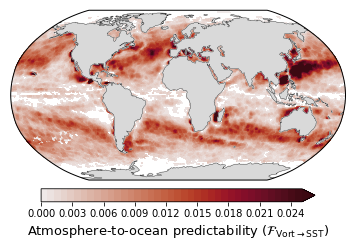

In [13]:
cmap = cmocean.cm.amp

plt.figure()
ax = plt.axes(projection=ccrs.Robinson())
ax.add_feature(cfeature.LAND, color='#D9D9D9', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.3)
ax.set_global()

var = data1['F_vort_to_sst'][:, 0]
var[data1['sig_vort_to_sst'][:, 0] > 0.05] = numpy.NaN
var = numpy.ma.masked_invalid(var)
vmin, vmax = 0, numpy.nanpercentile(var, 99)
levels = numpy.linspace(0, vmax, 40)

regridded = pyresample.kd_tree.resample_nearest(orig_def, var.flatten(), targ_def, radius_of_influence=500000,
                                                fill_value=None).reshape([241, 480])

regridded, lon_cyc = add_cyclic_point(regridded, coord=lon2)

plt.contourf(lon_cyc, lat2, regridded, 100, levels=levels,
             cmap=cmap, transform=ccrs.PlateCarree(),
             extend='max')
cb = plt.colorbar(orientation='horizontal', fraction=0.06, pad=0.04)
cb.set_label(r'Atmosphere-to-ocean predictability ($\mathcal{F}_{\mathrm{Vort}\rightarrow\mathrm{SST}}$)', size=13)
tick_locator = ticker.MaxNLocator(nbins=9)
cb.locator = tick_locator
cb.update_ticks()
plt.savefig('F_vort_to_sst.pdf')

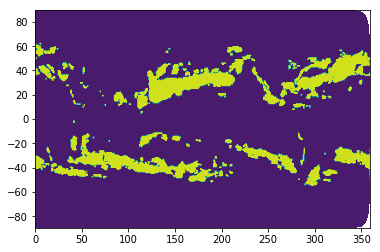

In [7]:
dat = data1['F_vort_to_sst'][:, 0]
mask = dat > 0.01
plt.tricontourf(lon, lat, dat > 0.01)

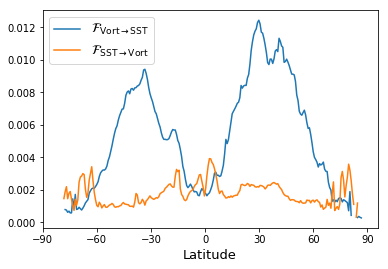

In [52]:
pts = []
pts2 = []
vort_to_sst = data1['F_vort_to_sst'][:, 0].load()
sst_to_vort = data1['F_sst_to_vort'][:, 0].load()

for l in numpy.unique(lat):
    pts.append((vort_to_sst[(data1['sig_vort_to_sst'][:, 0] < 0.05) & (lat == l)]).mean())
    pts2.append((sst_to_vort[(data1['sig_sst_to_vort'][:, 0] < 0.05) & (lat == l)]).mean())
plt.plot(numpy.unique(lat), pts)
plt.plot(numpy.unique(lat), pts2)
plt.xlabel('Latitude', size=13)
plt.xticks(numpy.linspace(-90, 90, 7))
plt.legend([r'$\mathcal{F}_{\mathrm{Vort}\rightarrow\mathrm{SST}}$', r'$\mathcal{F}_{\mathrm{SST}\rightarrow\mathrm{Vort}}$'], fontsize=13)
plt.savefig('zonal_average.pdf')

/homes/ebach/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]


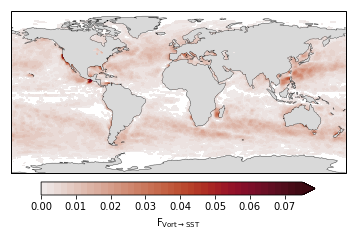

In [136]:
cmap = cmocean.cm.amp
levels = numpy.linspace(0, 0.075, 40)

plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, color='#D9D9D9')
ax.add_feature(cfeature.COASTLINE, linewidth=0.3)

lat = numpy.arange(-90, -90 + 241*0.75, 0.75)
lon = numpy.arange(0, 480*0.75, 0.75)

var_to_plot = scipy.io.loadmat('data/F_vort_to_sst_fixed.mat')['F_vort_to_sst'].T
var_to_plot[scipy.io.loadmat('data/sig_vort_to_sst_fixed.mat')['sig_vort_to_sst'].T > 0.05] = numpy.NaN

var_cyc, lon_cyc = add_cyclic_point(var_to_plot, coord=lon)
latt, lonn = numpy.meshgrid(lat, lon_cyc)
plt.contourf(lonn, latt, var_cyc.T, vmin=min(levels), vmax=max(levels),
             cmap=cmap, levels=levels, transform=ccrs.PlateCarree(),
             extend='max')
cb = plt.colorbar(orientation='horizontal', fraction=0.06, pad=0.04)
cb.set_label(r'$\mathrm{F}_{\mathrm{Vort}\rightarrow\mathrm{SST}}$')
tick_locator = ticker.MaxNLocator(nbins=9)
cb.locator = tick_locator
cb.update_ticks()
plt.savefig('F_vort_to_sst_fixed.pdf')

/homes/ebach/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]


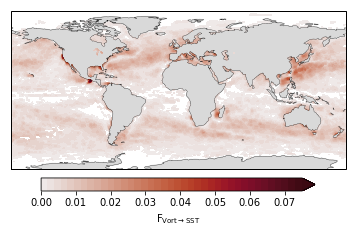

In [139]:
cmap = cmocean.cm.amp
levels = numpy.linspace(0, 0.075, 40)

plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, color='#D9D9D9')
ax.add_feature(cfeature.COASTLINE, linewidth=0.3)

lat = numpy.arange(-90, -90 + 241*0.75, 0.75)
lon = numpy.arange(0, 480*0.75, 0.75)

var_to_plot = scipy.io.loadmat('data/F_vort_to_sst_bic.mat')['F_vort_to_sst'].T
var_to_plot[scipy.io.loadmat('data/sig_vort_to_sst_bic.mat')['sig_vort_to_sst'].T > 0.05] = numpy.NaN

var_cyc, lon_cyc = add_cyclic_point(var_to_plot, coord=lon)
latt, lonn = numpy.meshgrid(lat, lon_cyc)
plt.contourf(lonn, latt, var_cyc.T, vmin=min(levels), vmax=max(levels),
             cmap=cmap, levels=levels, transform=ccrs.PlateCarree(),
             extend='max')
cb = plt.colorbar(orientation='horizontal', fraction=0.06, pad=0.04)
cb.set_label(r'$\mathrm{F}_{\mathrm{Vort}\rightarrow\mathrm{SST}}$')
tick_locator = ticker.MaxNLocator(nbins=9)
cb.locator = tick_locator
cb.update_ticks()
plt.savefig('F_vort_to_sst_bic.pdf')

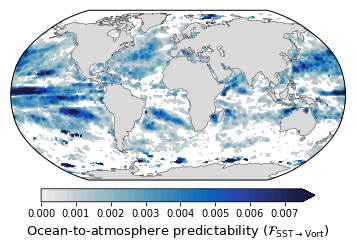

In [11]:
levels = numpy.linspace(0, 0.025, 40)
upper_half = numpy.linspace(0.5, 1, 40)
cmap = cmocean.cm.balance_r
colors = cmap(upper_half)
cmap = LinearSegmentedColormap.from_list('Upper Half', colors)

plt.figure()
ax = plt.axes(projection=ccrs.Robinson())
ax.add_feature(cfeature.LAND, color='#D9D9D9', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.3)
ax.set_global()

var = data1['F_sst_to_vort'][:, 0]
var[data1['sig_sst_to_vort'][:, 0] > 0.05] = numpy.NaN
var = numpy.ma.masked_invalid(var)
vmin, vmax = var.min(), numpy.nanpercentile(var, 99)
levels = numpy.linspace(0, vmax, 40)

regridded = pyresample.kd_tree.resample_nearest(orig_def, var.flatten(), targ_def, radius_of_influence=500000,
                                                fill_value=None).reshape([241, 480])

regridded, lon_cyc = add_cyclic_point(regridded, coord=lon2)

plt.contourf(lon_cyc, lat2, regridded, 100, vmin=min(levels), vmax=max(levels),
             cmap=cmap, levels=levels, transform=ccrs.PlateCarree(),
             extend='max')
cb = plt.colorbar(orientation='horizontal', fraction=0.06, pad=0.04)
cb.set_label(r'Ocean-to-atmosphere predictability ($\mathcal{F}_{\mathrm{SST}\rightarrow\mathrm{Vort}}$)', size=13)
tick_locator = ticker.MaxNLocator(nbins=9)
cb.locator = tick_locator
cb.update_ticks()
plt.savefig('F_sst_to_vort.pdf')

In [ ]:
levels = numpy.linspace(0, 0.025, 40)
upper_half = numpy.linspace(0.5, 1, 40)
cmap = cmocean.cm.balance_r
colors = cmap(upper_half)
cmap = LinearSegmentedColormap.from_list('Upper Half', colors)

plt.figure()
ax = plt.axes(projection=ccrs.Robinson())
ax.add_feature(cfeature.LAND, color='#D9D9D9', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.3)
ax.set_global()

var = 1 - 1/data1['F_sst_to_vort'][:, 0]
var[data1['sig_sst_to_vort'][:, 0] > 0.05] = numpy.NaN
var = numpy.ma.masked_invalid(var)
vmin, vmax = var.min(), var.max()
levels = numpy.linspace(0, vmax, 40)

regridded = pyresample.kd_tree.resample_nearest(orig_def, var.flatten(), targ_def, radius_of_influence=500000,
                                                fill_value=None).reshape([241, 480])

regridded, lon_cyc = add_cyclic_point(regridded, coord=lon2)

plt.contourf(lon_cyc, lat2, regridded, 100, vmin=min(levels), vmax=max(levels),
             cmap=cmap, levels=levels, transform=ccrs.PlateCarree(),
             extend='max')
cb = plt.colorbar(orientation='horizontal', fraction=0.06, pad=0.04)
cb.set_label(r'Ocean-to-atmosphere predictability ($\mathcal{F}_{\mathrm{SST}\rightarrow\mathrm{Vort}}$)', size=13)
tick_locator = ticker.MaxNLocator(nbins=9)
cb.locator = tick_locator
cb.update_ticks()


/homes/ebach/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


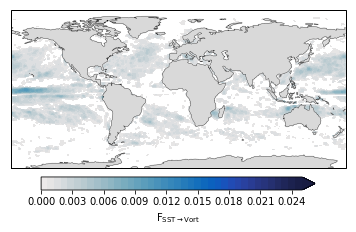

In [135]:
levels = numpy.linspace(0, 0.025, 40)
upper_half = numpy.linspace(0.5, 1, 40)
cmap = cmocean.cm.balance_r
colors = cmap(upper_half)
cmap = LinearSegmentedColormap.from_list('Upper Half', colors)

plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, color='#D9D9D9')
ax.add_feature(cfeature.COASTLINE, linewidth=0.3)

lat = numpy.arange(-90, -90 + 241*0.75, 0.75)
lon = numpy.arange(0, 480*0.75, 0.75)

var_to_plot = scipy.io.loadmat('data/F_sst_to_vort_fixed.mat')['F_sst_to_vort'].T
var_to_plot[scipy.io.loadmat('data/sig_sst_to_vort_fixed.mat')['sig_sst_to_vort'].T > 0.05] = numpy.NaN

var_cyc, lon_cyc = add_cyclic_point(var_to_plot, coord=lon)
latt, lonn = numpy.meshgrid(lat, lon_cyc)
plt.contourf(lonn, latt, var_cyc.T, vmin=min(levels), vmax=max(levels),
             cmap=cmap, levels=levels, transform=ccrs.PlateCarree(),
             extend='max')
cb = plt.colorbar(orientation='horizontal', fraction=0.06, pad=0.04)
cb.set_label(r'$\mathrm{F}_{\mathrm{SST}\rightarrow\mathrm{Vort}}$')
tick_locator = ticker.MaxNLocator(nbins=9)
cb.locator = tick_locator
cb.update_ticks()
plt.savefig('F_sst_to_vort_fixed.pdf')

/homes/ebach/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


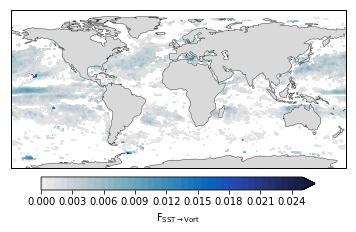

In [140]:
levels = numpy.linspace(0, 0.025, 40)
upper_half = numpy.linspace(0.5, 1, 40)
cmap = cmocean.cm.balance_r
colors = cmap(upper_half)
cmap = LinearSegmentedColormap.from_list('Upper Half', colors)

plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, color='#D9D9D9')
ax.add_feature(cfeature.COASTLINE, linewidth=0.3)

lat = numpy.arange(-90, -90 + 241*0.75, 0.75)
lon = numpy.arange(0, 480*0.75, 0.75)

var_to_plot = scipy.io.loadmat('data/F_sst_to_vort_bic.mat')['F_sst_to_vort'].T
var_to_plot[scipy.io.loadmat('data/sig_sst_to_vort_bic.mat')['sig_sst_to_vort'].T > 0.05] = numpy.NaN

var_cyc, lon_cyc = add_cyclic_point(var_to_plot, coord=lon)
latt, lonn = numpy.meshgrid(lat, lon_cyc)
plt.contourf(lonn, latt, var_cyc.T, vmin=min(levels), vmax=max(levels),
             cmap=cmap, levels=levels, transform=ccrs.PlateCarree(),
             extend='max')
cb = plt.colorbar(orientation='horizontal', fraction=0.06, pad=0.04)
cb.set_label(r'$\mathrm{F}_{\mathrm{SST}\rightarrow\mathrm{Vort}}$')
tick_locator = ticker.MaxNLocator(nbins=9)
cb.locator = tick_locator
cb.update_ticks()
plt.savefig('F_sst_to_vort_bic.pdf')

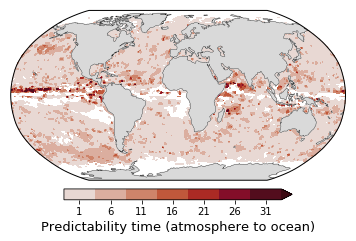

In [138]:
cmap = cmocean.cm.amp

plt.figure()
ax = plt.axes(projection=ccrs.Robinson(central_longitude=0))
ax.add_feature(cfeature.LAND, color='#D9D9D9', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.3)
ax.set_global()

var = persist_vort_to_sst.astype(float) + 1
var[data1['sig_vort_to_sst'][:, 0] > 0.05] = numpy.NaN
var = numpy.ma.masked_invalid(var)
vmin, vmax = var.min(), var.max()
levels = numpy.arange(-2.5, vmax + 5, 5) + 1

regridded = pyresample.kd_tree.resample_nearest(orig_def, var.flatten(), targ_def, radius_of_influence=500000,
                                                fill_value=None).reshape([241, 480])

regridded, lon_cyc = add_cyclic_point(regridded, coord=lon2)

plt.contourf(lon_cyc, lat2, regridded, vmin=min(levels), vmax=max(levels),
             cmap=cmap, levels=levels, transform=ccrs.PlateCarree(),
             extend='max')
cb = plt.colorbar(orientation='horizontal', fraction=0.05, pad=0.04, ticks=numpy.arange(0, 35, 5) + 1)
cb.set_label(r'Predictability time (atmosphere to ocean)', size=13)
plt.savefig('time_vort_to_sst.pdf')

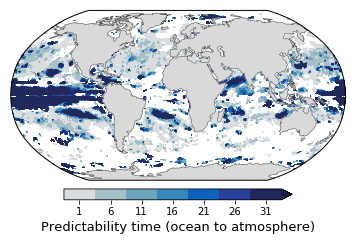

In [140]:
upper_half = numpy.linspace(0.5, 1, 40)
cmap = cmocean.cm.balance_r
colors = cmap(upper_half)
cmap = LinearSegmentedColormap.from_list('Upper Half', colors)
levels = numpy.arange(-2.5, 35, 5)

plt.figure()
ax = plt.axes(projection=ccrs.Robinson())
ax.add_feature(cfeature.LAND, color='#D9D9D9', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.3)
ax.set_global()

var = persist_sst_to_vort.astype(float) + 1
var[data1['sig_sst_to_vort'][:, 0] > 0.05] = numpy.NaN
var = numpy.ma.masked_invalid(var)
vmin, vmax = var.min(), var.max()
levels = numpy.arange(-2.5, vmax + 5, 5) + 1

regridded = pyresample.kd_tree.resample_nearest(orig_def, var.flatten(), targ_def, radius_of_influence=500000,
                                                fill_value=None).reshape([241, 480])

regridded, lon_cyc = add_cyclic_point(regridded, coord=lon2)

plt.contourf(lon_cyc, lat2, regridded, vmin=min(levels), vmax=max(levels),
             cmap=cmap, levels=levels, transform=ccrs.PlateCarree(),
             extend='max')
cb = plt.colorbar(orientation='horizontal', fraction=0.05, pad=0.04, ticks=numpy.arange(0, 35, 5) + 1)
cb.set_label(r'Predictability time (ocean to atmosphere)', size=13)
plt.savefig('time_sst_to_vort.pdf')

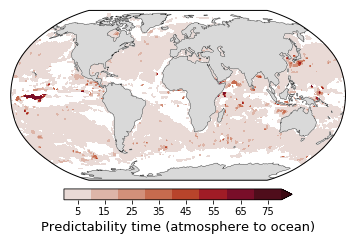

In [142]:
cmap = cmocean.cm.amp
levels = numpy.arange(-2.5, 80, 10)

plt.figure()
ax = plt.axes(projection=ccrs.Robinson())
ax.add_feature(cfeature.LAND, color='#D9D9D9', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.3)
ax.set_global()

var = persist5_vort_to_sst.astype(float)
var[data5['sig_vort_to_sst'][:, 0] > 0.05] = numpy.NaN
var = numpy.ma.masked_invalid(var)
vmin, vmax = var.min(), var.max()
levels = numpy.arange(-5, vmax + 10, 10) + 5

regridded = pyresample.kd_tree.resample_nearest(orig_def, var.flatten(), targ_def, radius_of_influence=500000,
                                                fill_value=None).reshape([241, 480])

regridded, lon_cyc = add_cyclic_point(regridded, coord=lon2)

plt.contourf(lon_cyc, lat2, regridded, vmin=min(levels), vmax=max(levels),
             cmap=cmap, levels=levels, transform=ccrs.PlateCarree(),
             extend='max')
cb = plt.colorbar(orientation='horizontal', fraction=0.05, pad=0.04, ticks=numpy.arange(0, 80, 10) + 5)
cb.set_label(r'Predictability time (atmosphere to ocean)', size=13)
plt.savefig('time5_vort_to_sst.pdf')

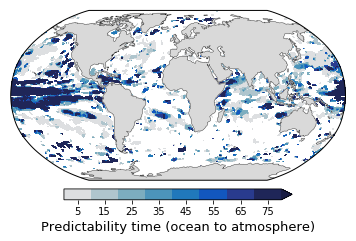

In [144]:
upper_half = numpy.linspace(0.5, 1, 40)
cmap = cmocean.cm.balance_r
colors = cmap(upper_half)
cmap = LinearSegmentedColormap.from_list('Upper Half', colors)
levels = numpy.arange(-5, 80, 10)

plt.figure()
ax = plt.axes(projection=ccrs.Robinson())
ax.add_feature(cfeature.LAND, color='#D9D9D9', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.3)
ax.set_global()

var = persist5_sst_to_vort.astype(float) + 5
var[data5['sig_sst_to_vort'][:, 0] > 0.05] = numpy.NaN
var = numpy.ma.masked_invalid(var)
vmin, vmax = var.min(), var.max()
levels = numpy.arange(-5, vmax + 10, 10) + 5

regridded = pyresample.kd_tree.resample_nearest(orig_def, var.flatten(), targ_def, radius_of_influence=500000,
                                                fill_value=None).reshape([241, 480])

regridded, lon_cyc = add_cyclic_point(regridded, coord=lon2)

plt.contourf(lon_cyc, lat2, regridded, vmin=min(levels), vmax=max(levels),
             cmap=cmap, levels=levels, transform=ccrs.PlateCarree(),
             extend='max')
cb = plt.colorbar(orientation='horizontal', fraction=0.05, pad=0.04, ticks=numpy.arange(0, 80, 10) + 5)
cb.set_label(r'Predictability time (ocean to atmosphere)', size=13)
plt.savefig('time5_sst_to_vort.pdf')

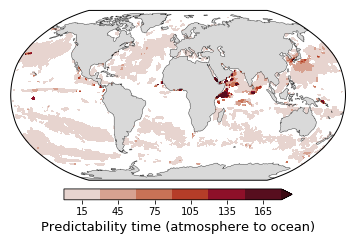

In [17]:
cmap = cmocean.cm.amp
levels = numpy.arange(-15, 180, 30)

plt.figure()
ax = plt.axes(projection=ccrs.Robinson())
ax.add_feature(cfeature.LAND, color='#D9D9D9')
ax.add_feature(cfeature.COASTLINE, linewidth=0.3)
ax.set_global()

var = persist15_vort_to_sst.astype(float) + 15
var[data15['sig_vort_to_sst'][:, 0] > 0.05] = numpy.NaN
var = numpy.ma.masked_invalid(var)
vmin, vmax = var.min(), var.max()
levels = numpy.arange(-15, vmax + 30, 30) + 15

regridded = pyresample.kd_tree.resample_nearest(orig_def, var.flatten(), targ_def, radius_of_influence=500000,
                                                fill_value=None).reshape([241, 480])

regridded, lon_cyc = add_cyclic_point(regridded, coord=lon2)

plt.contourf(lon_cyc, lat2, regridded, vmin=min(levels), vmax=max(levels),
             cmap=cmap, levels=levels, transform=ccrs.PlateCarree(),
             extend='max')
cb = plt.colorbar(orientation='horizontal', fraction=0.05, pad=0.04, ticks=numpy.arange(0, 180, 30) + 15)
cb.set_label(r'Predictability time (atmosphere to ocean)', size=13)
plt.savefig('time15_vort_to_sst.pdf')

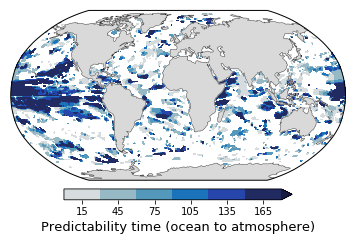

In [7]:
upper_half = numpy.linspace(0.5, 1, 40)
cmap = cmocean.cm.balance_r
colors = cmap(upper_half)
cmap = LinearSegmentedColormap.from_list('Upper Half', colors)
levels = numpy.arange(-15, 180, 30)

plt.figure()
ax = plt.axes(projection=ccrs.Robinson())
ax.add_feature(cfeature.LAND, color='#D9D9D9', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.3)
ax.set_global()

var = persist15_sst_to_vort.astype(float) + 15
var[data15['sig_sst_to_vort'][:, 0] > 0.05] = numpy.NaN
var = numpy.ma.masked_invalid(var)
vmin, vmax = var.min(), var.max()
levels = numpy.arange(-15, vmax + 30, 30) + 15

regridded = pyresample.kd_tree.resample_nearest(orig_def, var.flatten(), targ_def, radius_of_influence=500000,
                                                fill_value=None).reshape([241, 480])

regridded, lon_cyc = add_cyclic_point(regridded, coord=lon2)

plt.contourf(lon_cyc, lat2, regridded, vmin=min(levels), vmax=max(levels),
             cmap=cmap, levels=levels, transform=ccrs.PlateCarree(),
             extend='max')
cb = plt.colorbar(orientation='horizontal', fraction=0.05, pad=0.04, ticks=numpy.arange(0, 180, 30) + 15)
cb.set_label(r'Predictability time (ocean to atmosphere)', size=13)
plt.savefig('time15_sst_to_vort.pdf')

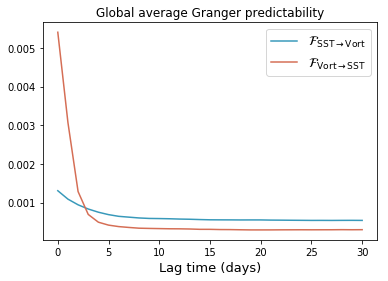

In [6]:
# Decay of predictability with time
plt.plot((data1['F_sst_to_vort'].mean(axis=0)), '#3899BA')
plt.plot((data1['F_vort_to_sst'].mean(axis=0)), '#D56E55')
plt.legend([r'$\mathcal{F}_{\mathrm{SST}\rightarrow \mathrm{Vort}}$',
            r'$\mathcal{F}_{\mathrm{Vort}\rightarrow \mathrm{SST}}$'], fontsize=13)
plt.title('Global average Granger predictability')
plt.xlabel('Lag time (days)', size=13)

plt.savefig('predictability_decay.pdf')

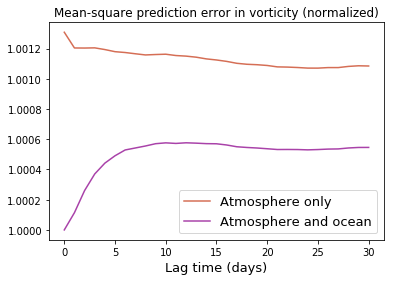

In [8]:
# MSPE increase
mspe_vort = numpy.exp(-(data1['F_sst_to_vort'] - numpy.log(data1['mspe_sst_to_vort'])))
mspe_sst = numpy.exp(-(data1['F_vort_to_sst'] - numpy.log(data1['mspe_vort_to_sst'])))

plt.plot((data1['mspe_sst_to_vort']/mspe_vort[:, 0]).mean(axis=0), '#D56E55')
plt.plot((mspe_vort/mspe_vort[:, 0]).mean(axis=0), '#A942A9')
plt.legend(['Atmosphere only', 'Atmosphere and ocean'], fontsize=13)
plt.title('Mean-square prediction error in vorticity (normalized)')
plt.xlabel('Lag time (days)', size=13)

plt.savefig('mspe_sst_to_vort.pdf')

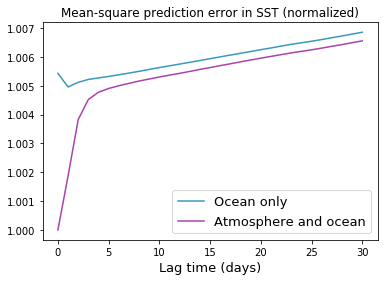

In [4]:
plt.plot((data1['mspe_vort_to_sst']/mspe_sst[:, 0]).mean(axis=0), '#3899BA')
plt.plot((mspe_sst/mspe_sst[:, 0]).mean(axis=0), '#A942A9')
plt.legend(['Ocean only', 'Atmosphere and ocean'], fontsize=13)
plt.title('Mean-square prediction error in SST (normalized)')
plt.xlabel('Lag time (days)', size=13)

plt.savefig('mspe_vort_to_sst.pdf')

Text(0.5,0,'Lag time (days)')

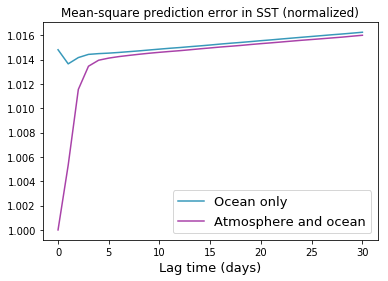

In [12]:
plt.plot((data1['mspe_vort_to_sst']/mspe_sst[:, 0])[mask.values, :].mean(axis=0), '#3899BA')
plt.plot((mspe_sst/mspe_sst[:, 0])[mask.values, :].mean(axis=0), '#A942A9')
plt.legend(['Ocean only', 'Atmosphere and ocean'], fontsize=13)
plt.title('Mean-square prediction error in SST (normalized)')
plt.xlabel('Lag time (days)', size=13)

In [14]:
data1['mspe_vort_to_sst'][mask.values, 0].mean(axis=0)

<xarray.DataArray 'mspe_vort_to_sst' ()>
array(0.026315777595097147)
Coordinates:
    delay    int64 0

In [15]:
data1['mspe_vort_to_sst'][:, 0].mean(axis=0)

<xarray.DataArray 'mspe_vort_to_sst' ()>
array(0.0319574696513772)
Coordinates:
    delay    int64 0

In [16]:
mspe_sst[:, 0].mean(axis=0)

<xarray.DataArray ()>
array(0.031821312215200126)
Coordinates:
    delay    int64 0

In [1]:
0.0319574696513772 - 0.031821312215200126

0.0001361574361770715

In [17]:
mspe_sst[mask.values, 0].mean(axis=0)

<xarray.DataArray ()>
array(0.025920548393107617)
Coordinates:
    delay    int64 0

In [2]:
0.026315777595097147-0.025920548393107617

0.0003952292019895297

In [19]:
0.0319574696513772/0.031821312215200126

1.0042788127421105

In [37]:
numpy.nanmean(1 - data1['mspe_sst_to_vort'][:, 0]/a)

0.17391780131440016

In [38]:
numpy.nanmean(1 - mspe_vort[:, 0]/a)

0.17497017247591623

In [41]:
# Boreal summer
mspe_sst = numpy.hstack([data_summer['mspe_sst_to_vort'][lat > 0], data_winter['mspe_sst_to_vort'][lat < 0]])
numpy.nanmean(mspe_sst)

3.0421322914370821e-10

In [42]:
# Boreal winter
mspe_sst = numpy.hstack([data_summer['mspe_sst_to_vort'][lat < 0], data_winter['mspe_sst_to_vort'][lat > 0]])
numpy.nanmean(mspe_sst)

4.0286699120731866e-10

In [43]:
mspe_summer = numpy.exp(-(data_summer['F_sst_to_vort'] - numpy.log(data_summer['mspe_sst_to_vort'])))
mspe_winter = numpy.exp(-(data_winter['F_sst_to_vort'] - numpy.log(data_winter['mspe_sst_to_vort'])))

In [44]:
# Boreal summer
mspe_sst = numpy.hstack([mspe_summer[lat > 0], mspe_winter[lat < 0]])
numpy.nanmean(mspe_sst)

3.0326533818617133e-10

In [45]:
# Boreal winter 
mspe_sst = numpy.hstack([mspe_winter[lat > 0], mspe_summer[lat < 0]])
numpy.nanmean(mspe_sst)

4.0216990296829605e-10

In [39]:
0.046129322815650124 - 0.04572895360630317

0.0004003692093469541

In [40]:
0.021938785034931983 - 0.021855043898393649

8.374113653833448e-05

In [120]:
pts = []
for l in numpy.unique(lat):
    pts.append((data1['mspe_sst_to_vort']/mspe_vort[:, 0])[lat == l].mean(axis=0))

pts = numpy.array(pts)

-89.4628215686 -67.7190325873


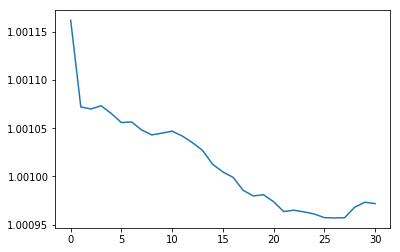

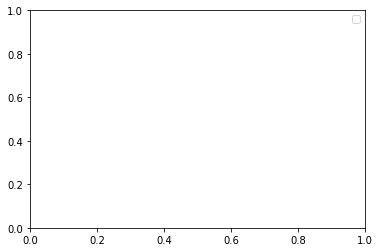

In [129]:
for i, l in enumerate(numpy.nanmean(pts.reshape([1, 256//1, 31]), axis=1)):
    ran = numpy.unique(lat).reshape([8, 256//8])[i]
    print(ran[0], ran[-1])
    plt.plot(l)
    plt.show()
plt.legend(numpy.linspace(-90, 90, 8))

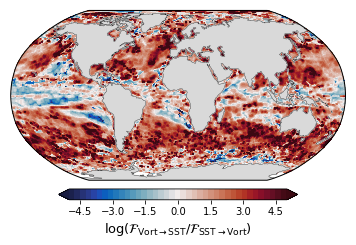

In [4]:
plt.figure()
ax = plt.axes(projection=ccrs.Robinson())
ax.add_feature(cfeature.LAND, color='#D9D9D9', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.3, zorder=1)
ax.set_global()

ratio = numpy.log(data5['F_vort_to_sst'][:, 0]/data5['F_sst_to_vort'][:, 0])

var = numpy.ma.masked_invalid(ratio)

regridded = pyresample.kd_tree.resample_nearest(orig_def, var.flatten(), targ_def, radius_of_influence=500000,
                                                fill_value=None).reshape([241, 480])

regridded, lon_cyc = add_cyclic_point(regridded, coord=lon2)

plt.contourf(lon_cyc, lat2, regridded, levels=numpy.linspace(-5, 5, 40), cmap=cmocean.cm.balance,
             vmax=5, vmin=-5, extend='both', transform=ccrs.PlateCarree())
cb = plt.colorbar(orientation='horizontal', fraction=0.05, pad=0.04)
tick_locator = ticker.MaxNLocator(nbins=9)
cb.locator = tick_locator
cb.update_ticks()
cb.set_label(r'$\log\left(\mathcal{F}_{\mathrm{Vort}\rightarrow \mathrm{SST}}/\mathcal{F}_{\mathrm{SST}\rightarrow \mathrm{Vort}}\right)$', size=13)
plt.savefig('map_comparison_ratio_pentad.pdf')

In [3]:
data_winter = xarray.open_dataset('data/data_winter.nc')
data_spring = xarray.open_dataset('data/data_spring.nc')
data_summer = xarray.open_dataset('data/data_summer.nc')
data_fall = xarray.open_dataset('data/data_fall.nc')

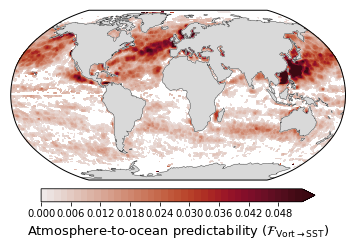

In [8]:
cmap = cmocean.cm.amp

plt.figure()
ax = plt.axes(projection=ccrs.Robinson())
ax.add_feature(cfeature.LAND, color='#D9D9D9', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.3)
ax.set_global()

var = data_summer['F_vort_to_sst'].copy()
var[data_summer['sig_vort_to_sst'] > 0.05] = numpy.NaN
var = numpy.ma.masked_invalid(var)
vmin, vmax = var.min(), 0.0528
levels = numpy.linspace(0, vmax, 40)

regridded = pyresample.kd_tree.resample_nearest(orig_def, var.flatten(), targ_def, radius_of_influence=500000,
                                                fill_value=None).reshape([241, 480])

regridded, lon_cyc = add_cyclic_point(regridded, coord=lon2)

plt.contourf(lon_cyc, lat2, regridded, 100, levels=levels,
             cmap=cmap, transform=ccrs.PlateCarree(),
             extend='max')
cb = plt.colorbar(orientation='horizontal', fraction=0.06, pad=0.04)
cb.set_label(r'Atmosphere-to-ocean predictability ($\mathcal{F}_{\mathrm{Vort}\rightarrow\mathrm{SST}}$)', size=13)
tick_locator = ticker.MaxNLocator(nbins=9)
cb.locator = tick_locator
cb.update_ticks()
plt.savefig('F_vort_to_sst_summer.pdf')

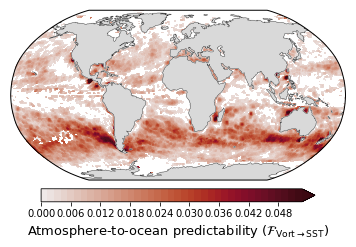

In [9]:
cmap = cmocean.cm.amp

plt.figure()
ax = plt.axes(projection=ccrs.Robinson())
ax.add_feature(cfeature.LAND, color='#D9D9D9', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.3)
ax.set_global()

var = data_winter['F_vort_to_sst'].copy()
var[data_winter['sig_vort_to_sst'] > 0.05] = numpy.NaN
var = numpy.ma.masked_invalid(var)
vmin, vmax = var.min(), 0.0528
levels = numpy.linspace(0, vmax, 40)

regridded = pyresample.kd_tree.resample_nearest(orig_def, var.flatten(), targ_def, radius_of_influence=500000,
                                                fill_value=None).reshape([241, 480])

regridded, lon_cyc = add_cyclic_point(regridded, coord=lon2)

plt.contourf(lon_cyc, lat2, regridded, 100, levels=levels,
             cmap=cmap, transform=ccrs.PlateCarree(),
             extend='max')
cb = plt.colorbar(orientation='horizontal', fraction=0.06, pad=0.04)
cb.set_label(r'Atmosphere-to-ocean predictability ($\mathcal{F}_{\mathrm{Vort}\rightarrow\mathrm{SST}}$)', size=13)
tick_locator = ticker.MaxNLocator(nbins=9)
cb.locator = tick_locator
cb.update_ticks()
plt.savefig('F_vort_to_sst_winter.pdf')

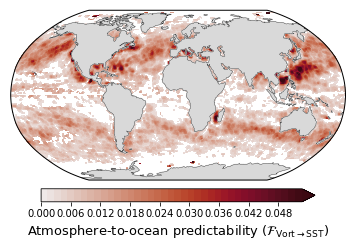

In [10]:
cmap = cmocean.cm.amp

plt.figure()
ax = plt.axes(projection=ccrs.Robinson())
ax.add_feature(cfeature.LAND, color='#D9D9D9', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.3)
ax.set_global()

var = data_fall['F_vort_to_sst'].copy()
var[data_fall['sig_vort_to_sst'] > 0.05] = numpy.NaN
var = numpy.ma.masked_invalid(var)
vmin, vmax = var.min(), 0.0528
levels = numpy.linspace(0, vmax, 40)

regridded = pyresample.kd_tree.resample_nearest(orig_def, var.flatten(), targ_def, radius_of_influence=500000,
                                                fill_value=None).reshape([241, 480])

regridded, lon_cyc = add_cyclic_point(regridded, coord=lon2)

plt.contourf(lon_cyc, lat2, regridded, 100, levels=levels,
             cmap=cmap, transform=ccrs.PlateCarree(),
             extend='max')
cb = plt.colorbar(orientation='horizontal', fraction=0.06, pad=0.04)
cb.set_label(r'Atmosphere-to-ocean predictability ($\mathcal{F}_{\mathrm{Vort}\rightarrow\mathrm{SST}}$)', size=13)
tick_locator = ticker.MaxNLocator(nbins=9)
cb.locator = tick_locator
cb.update_ticks()
plt.savefig('F_vort_to_sst_fall.pdf')

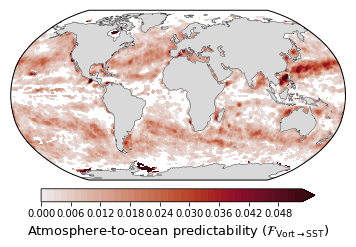

In [11]:
cmap = cmocean.cm.amp

plt.figure()
ax = plt.axes(projection=ccrs.Robinson())
ax.add_feature(cfeature.LAND, color='#D9D9D9', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.3)
ax.set_global()

var = data_spring['F_vort_to_sst'].copy()
var[data_spring['sig_vort_to_sst'] > 0.05] = numpy.NaN
var = numpy.ma.masked_invalid(var)
vmin, vmax = var.min(), 0.0528
levels = numpy.linspace(0, vmax, 40)

regridded = pyresample.kd_tree.resample_nearest(orig_def, var.flatten(), targ_def, radius_of_influence=500000,
                                                fill_value=None).reshape([241, 480])

regridded, lon_cyc = add_cyclic_point(regridded, coord=lon2)

plt.contourf(lon_cyc, lat2, regridded, 100, levels=levels,
             cmap=cmap, transform=ccrs.PlateCarree(),
             extend='max')
cb = plt.colorbar(orientation='horizontal', fraction=0.06, pad=0.04)
cb.set_label(r'Atmosphere-to-ocean predictability ($\mathcal{F}_{\mathrm{Vort}\rightarrow\mathrm{SST}}$)', size=13)
tick_locator = ticker.MaxNLocator(nbins=9)
cb.locator = tick_locator
cb.update_ticks()
plt.savefig('F_vort_to_sst_spring.pdf')

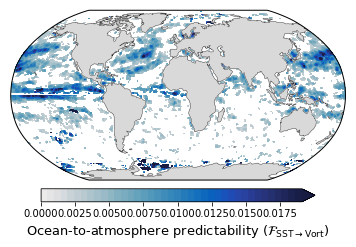

In [12]:
levels = numpy.linspace(0, 0.025, 40)
upper_half = numpy.linspace(0.5, 1, 40)
cmap = cmocean.cm.balance_r
colors = cmap(upper_half)
cmap = LinearSegmentedColormap.from_list('Upper Half', colors)

plt.figure()
ax = plt.axes(projection=ccrs.Robinson())
ax.add_feature(cfeature.LAND, color='#D9D9D9', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.3)
ax.set_global()

var = data_summer['F_sst_to_vort']
var[data_summer['sig_sst_to_vort'] > 0.05] = numpy.NaN
var = numpy.ma.masked_invalid(var)
vmin, vmax = var.min(), numpy.nanpercentile(var, 99)
levels = numpy.linspace(0, vmax, 40)

regridded = pyresample.kd_tree.resample_nearest(orig_def, var.flatten(), targ_def, radius_of_influence=500000,
                                                fill_value=None).reshape([241, 480])

regridded, lon_cyc = add_cyclic_point(regridded, coord=lon2)

plt.contourf(lon_cyc, lat2, regridded, 100, vmin=min(levels), vmax=max(levels),
             cmap=cmap, levels=levels, transform=ccrs.PlateCarree(),
             extend='max')
cb = plt.colorbar(orientation='horizontal', fraction=0.06, pad=0.04)
cb.set_label(r'Ocean-to-atmosphere predictability ($\mathcal{F}_{\mathrm{SST}\rightarrow\mathrm{Vort}}$)', size=13)
tick_locator = ticker.MaxNLocator(nbins=9)
cb.locator = tick_locator
cb.update_ticks()
plt.savefig('F_sst_to_vort_summer.pdf')

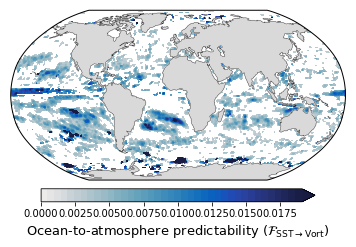

In [16]:
levels = numpy.linspace(0, 0.025, 40)
upper_half = numpy.linspace(0.5, 1, 40)
cmap = cmocean.cm.balance_r
colors = cmap(upper_half)
cmap = LinearSegmentedColormap.from_list('Upper Half', colors)

plt.figure()
ax = plt.axes(projection=ccrs.Robinson())
ax.add_feature(cfeature.LAND, color='#D9D9D9', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.3)
ax.set_global()

var = data_winter['F_sst_to_vort']
var[data_winter['sig_sst_to_vort'] > 0.05] = numpy.NaN
var = numpy.ma.masked_invalid(var)
vmin, vmax = var.min(), 0.0191
levels = numpy.linspace(0, vmax, 40)

regridded = pyresample.kd_tree.resample_nearest(orig_def, var.flatten(), targ_def, radius_of_influence=500000,
                                                fill_value=None).reshape([241, 480])

regridded, lon_cyc = add_cyclic_point(regridded, coord=lon2)

plt.contourf(lon_cyc, lat2, regridded, 100, vmin=min(levels), vmax=max(levels),
             cmap=cmap, levels=levels, transform=ccrs.PlateCarree(),
             extend='max')
cb = plt.colorbar(orientation='horizontal', fraction=0.06, pad=0.04)
cb.set_label(r'Ocean-to-atmosphere predictability ($\mathcal{F}_{\mathrm{SST}\rightarrow\mathrm{Vort}}$)', size=13)
tick_locator = ticker.MaxNLocator(nbins=9)
cb.locator = tick_locator
cb.update_ticks()
plt.savefig('F_sst_to_vort_winter.pdf')

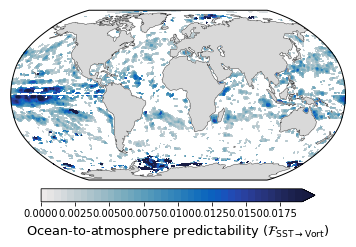

In [17]:
levels = numpy.linspace(0, 0.025, 40)
upper_half = numpy.linspace(0.5, 1, 40)
cmap = cmocean.cm.balance_r
colors = cmap(upper_half)
cmap = LinearSegmentedColormap.from_list('Upper Half', colors)

plt.figure()
ax = plt.axes(projection=ccrs.Robinson())
ax.add_feature(cfeature.LAND, color='#D9D9D9', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.3)
ax.set_global()

var = data_fall['F_sst_to_vort']
var[data_fall['sig_sst_to_vort'] > 0.05] = numpy.NaN
var = numpy.ma.masked_invalid(var)
vmin, vmax = var.min(), 0.0191
levels = numpy.linspace(0, vmax, 40)

regridded = pyresample.kd_tree.resample_nearest(orig_def, var.flatten(), targ_def, radius_of_influence=500000,
                                                fill_value=None).reshape([241, 480])

regridded, lon_cyc = add_cyclic_point(regridded, coord=lon2)

plt.contourf(lon_cyc, lat2, regridded, 100, vmin=min(levels), vmax=max(levels),
             cmap=cmap, levels=levels, transform=ccrs.PlateCarree(),
             extend='max')
cb = plt.colorbar(orientation='horizontal', fraction=0.06, pad=0.04)
cb.set_label(r'Ocean-to-atmosphere predictability ($\mathcal{F}_{\mathrm{SST}\rightarrow\mathrm{Vort}}$)', size=13)
tick_locator = ticker.MaxNLocator(nbins=9)
cb.locator = tick_locator
cb.update_ticks()
plt.savefig('F_sst_to_vort_fall.pdf')

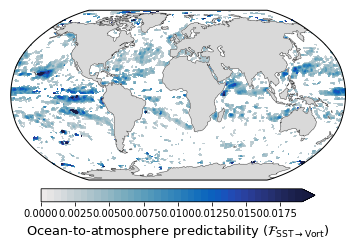

In [18]:
levels = numpy.linspace(0, 0.025, 40)
upper_half = numpy.linspace(0.5, 1, 40)
cmap = cmocean.cm.balance_r
colors = cmap(upper_half)
cmap = LinearSegmentedColormap.from_list('Upper Half', colors)

plt.figure()
ax = plt.axes(projection=ccrs.Robinson())
ax.add_feature(cfeature.LAND, color='#D9D9D9', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.3)
ax.set_global()

var = data_spring['F_sst_to_vort']
var[data_spring['sig_sst_to_vort'] > 0.05] = numpy.NaN
var = numpy.ma.masked_invalid(var)
vmin, vmax = var.min(), 0.0191
levels = numpy.linspace(0, vmax, 40)

regridded = pyresample.kd_tree.resample_nearest(orig_def, var.flatten(), targ_def, radius_of_influence=500000,
                                                fill_value=None).reshape([241, 480])

regridded, lon_cyc = add_cyclic_point(regridded, coord=lon2)

plt.contourf(lon_cyc, lat2, regridded, 100, vmin=min(levels), vmax=max(levels),
             cmap=cmap, levels=levels, transform=ccrs.PlateCarree(),
             extend='max')
cb = plt.colorbar(orientation='horizontal', fraction=0.06, pad=0.04)
cb.set_label(r'Ocean-to-atmosphere predictability ($\mathcal{F}_{\mathrm{SST}\rightarrow\mathrm{Vort}}$)', size=13)
tick_locator = ticker.MaxNLocator(nbins=9)
cb.locator = tick_locator
cb.update_ticks()
plt.savefig('F_sst_to_vort_spring.pdf')

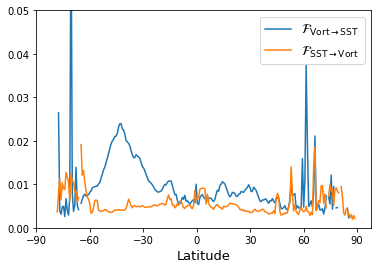

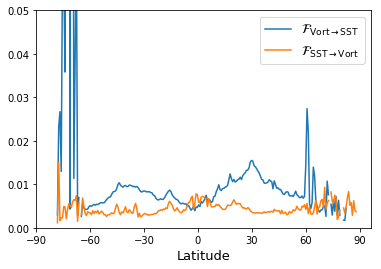

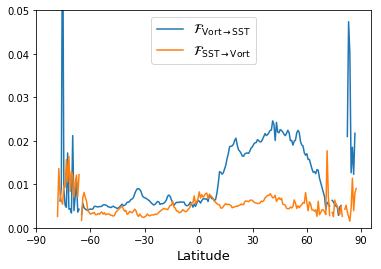

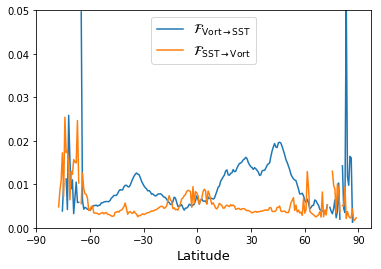

In [5]:
for season in [data_winter, data_spring, data_summer, data_fall]:
    pts = []
    pts2 = []

    vort_to_sst = season['F_vort_to_sst'].load()
    sst_to_vort = season['F_sst_to_vort'].load()

    for l in numpy.unique(lat):
        pts.append((vort_to_sst[(season['sig_vort_to_sst'] < 0.05) & (lat == l)]).mean())
        pts2.append((sst_to_vort[(season['sig_sst_to_vort'] < 0.05) & (lat == l)]).mean())
    plt.plot(numpy.unique(lat), pts)
    plt.plot(numpy.unique(lat), pts2)
    plt.ylim([0, 0.05])
    plt.xlabel('Latitude', size=13)
    plt.xticks(numpy.linspace(-90, 90, 7))
    plt.legend([r'$\mathcal{F}_{\mathrm{Vort}\rightarrow\mathrm{SST}}$', r'$\mathcal{F}_{\mathrm{SST}\rightarrow\mathrm{Vort}}$'], fontsize=13)
    plt.show()
    #plt.savefig('zonal_average.pdf')

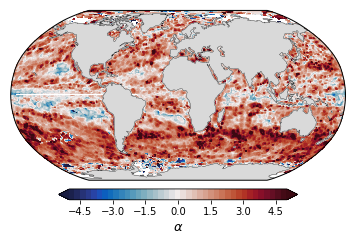

In [4]:
plt.figure()
ax = plt.axes(projection=ccrs.Robinson())
ax.add_feature(cfeature.LAND, color='#D9D9D9', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.3, zorder=1)
ax.set_global()

ratio = numpy.log(data_winter['F_vort_to_sst']/data_winter['F_sst_to_vort'])

var = numpy.ma.masked_invalid(ratio)

regridded = pyresample.kd_tree.resample_nearest(orig_def, var.flatten(), targ_def, radius_of_influence=500000,
                                                fill_value=None).reshape([241, 480])

regridded, lon_cyc = add_cyclic_point(regridded, coord=lon2)

plt.contourf(lon_cyc, lat2, regridded, levels=numpy.linspace(-5, 5, 40), cmap=cmocean.cm.balance,
             vmax=5, vmin=-5, extend='both', transform=ccrs.PlateCarree())
cb = plt.colorbar(orientation='horizontal', fraction=0.05, pad=0.04)
tick_locator = ticker.MaxNLocator(nbins=9)
cb.locator = tick_locator
cb.update_ticks()
cb.set_label(r'$\alpha$', size=13)

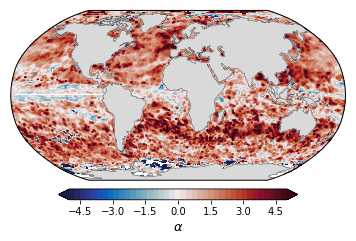

In [5]:
plt.figure()
ax = plt.axes(projection=ccrs.Robinson())
ax.add_feature(cfeature.LAND, color='#D9D9D9', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.3, zorder=1)
ax.set_global()

ratio = numpy.log(data_summer['F_vort_to_sst']/data_summer['F_sst_to_vort'])

var = numpy.ma.masked_invalid(ratio)

regridded = pyresample.kd_tree.resample_nearest(orig_def, var.flatten(), targ_def, radius_of_influence=500000,
                                                fill_value=None).reshape([241, 480])

regridded, lon_cyc = add_cyclic_point(regridded, coord=lon2)

plt.contourf(lon_cyc, lat2, regridded, levels=numpy.linspace(-5, 5, 40), cmap=cmocean.cm.balance,
             vmax=5, vmin=-5, extend='both', transform=ccrs.PlateCarree())
cb = plt.colorbar(orientation='horizontal', fraction=0.05, pad=0.04)
tick_locator = ticker.MaxNLocator(nbins=9)
cb.locator = tick_locator
cb.update_ticks()
cb.set_label(r'$\alpha$', size=13)

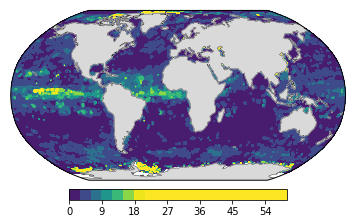

In [25]:
plt.figure()
ax = plt.axes(projection=ccrs.Robinson())
ax.add_feature(cfeature.LAND, color='#D9D9D9', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.3, zorder=1)
ax.set_global()

ratio = data1['times'][:, 0]

var = numpy.ma.masked_invalid(ratio)

regridded = pyresample.kd_tree.resample_nearest(orig_def, var.flatten(), targ_def, radius_of_influence=500000,
                                                fill_value=None).reshape([241, 480])

regridded, lon_cyc = add_cyclic_point(regridded, coord=lon2)

plt.contourf(lon_cyc, lat2, regridded, 20, vmax=20,
             transform=ccrs.PlateCarree())
cb = plt.colorbar(orientation='horizontal', fraction=0.05, pad=0.04)
#tick_locator = ticker.MaxNLocator(nbins=9)
#cb.locator = tick_locator
#cb.update_ticks()
#cb.set_label(r'$\alpha$', size=13)